# Overfitting y Regularización

El **overfitting** o sobreajuste es otro problema común al entrenar un modelo de aprendizaje automático. Consiste en entrenar modelos que aprenden a la perfección los datos de entrenamiento, perdiendo de esta forma generalidad. De modo, que si al modelo se le pasan datos nuevos que jamás ha visto, no será capaz de realizar una buena predicción.

Existe un problema opuesto al overfitting conocido como **underfitting** o subajuste, en el que el modelo no logra realizar una predicción ni siquiera cercana a los datos de entrenamiento y esta lejos de hacer una generalización.

![](https://drive.google.com/uc?id=15e1qtMWMYJA4HAc8eAhOt90DWMzeYEeG)

Para evitar el underfitting y el overfitting se pueden utilizar curvas de **loss**, **f1_score** o **accuracy** utilizando los datos de entrenamiento y validación. Haciendo un análisis sobre estas curvas se logra identificar estos problemas.

# Ejercicio

Utilizar el dataset [MNIST](http://yann.lecun.com/exdb/mnist/) para identificar los problemas de **underfitting**  y **overfitting**, utilizando una ANN de capas lineales.

In [1]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip mnist.zip

In [2]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [3]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [4]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [7]:
#--- Visualizamos el tamaño de cada subset
len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

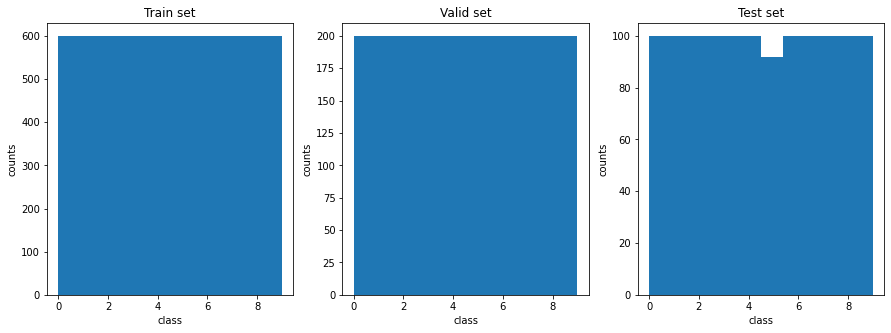

In [8]:
#--- Visualizamos la distribución de clases en cada subset
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

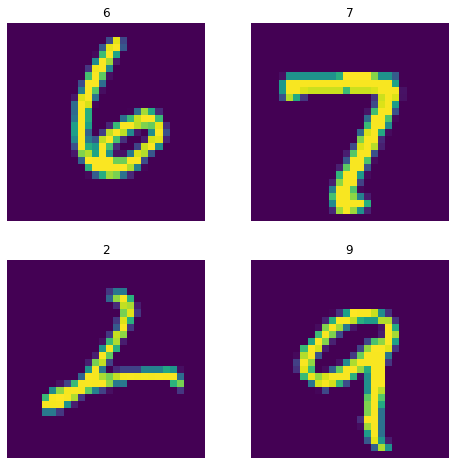

In [9]:
#-- Visualizamos los datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [10]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [11]:
#--- Definimos una función que nos permita entrenar diferentes modelos de ANN

from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)  

  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()

## Underfitting

El **underfitting** o sub ajuste se puede presentar en las siguientes situaciones:

* **Finalización temprana**: Cuando el modelo se entrena hasta una época temprana a pesar de que la tendencia indica una posible obtención de mejores resultados.

* **Modelo Simple**: Cuando el modelo es tan básico que no es capaz de extraer ningún tipo de patrón efectivo que le permita hacer una generalización de los datos.

Epoch [1/30], loss: 82.7890396118164. f1:0.05964657044852658 acc: 0.07566666603088379 
Epoch [2/30], loss: 61.263427734375. f1:0.08784221256913727 acc: 0.09183333069086075 
Epoch [3/30], loss: 48.82123947143555. f1:0.1282069288494235 acc: 0.1354999989271164 
Epoch [4/30], loss: 40.34152603149414. f1:0.17930513697635247 acc: 0.18299999833106995 
Epoch [5/30], loss: 33.02478790283203. f1:0.24577804287304678 acc: 0.2433333396911621 
Epoch [6/30], loss: 25.911191940307617. f1:0.3352531185501092 acc: 0.33000001311302185 
Epoch [7/30], loss: 20.18494415283203. f1:0.42613360918517024 acc: 0.4216666519641876 
Epoch [8/30], loss: 16.217782974243164. f1:0.5030440949485462 acc: 0.49966666102409363 
Epoch [9/30], loss: 13.666893005371094. f1:0.571786958062668 acc: 0.5718333125114441 
Epoch [10/30], loss: 11.927987098693848. f1:0.6163640745735542 acc: 0.6200000047683716 
Epoch [11/30], loss: 10.71108341217041. f1:0.6544728235655375 acc: 0.6598333120346069 
Epoch [12/30], loss: 9.800261497497559. f1

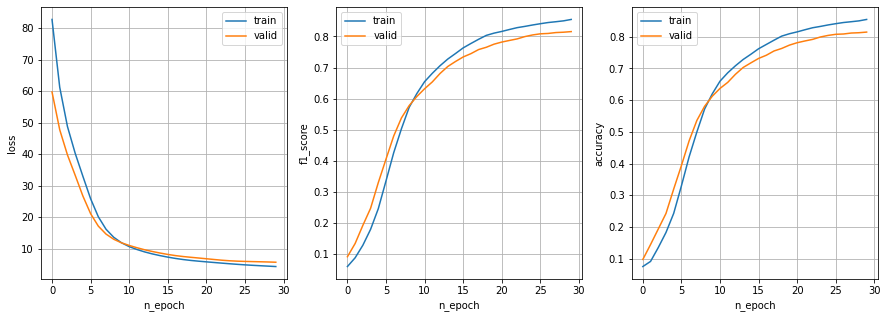

In [12]:
#--- Definimos una ANN simple para identificar un error de underfitting

input_dim = 28*28
out_dim = 10 

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

train_valid(model,30,optimizer,criterion)

In [13]:
#-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 4.583886623382568, f1: 0.8373949440543589, acc: 0.8377016186714172


## Overfitting

El **overfitting** o sobreajuste es el caso opuesto al subajuste y se puede presentar en la siguiente situación:
una obtención de mejores resultados.

* **Modelo Complejo**: El modelo es tan complejo que aprendió perfectamente los datos de entrenamiento, perdiendo generalidad. Cuando el modelo vea datos nuevos, diferentes a los del entrenamiento, su predicción será errónea.


Epoch [1/100], loss: 2.316589117050171. f1:0.03918674835607137 acc: 0.09399999678134918 
Epoch [2/100], loss: 2.261753797531128. f1:0.0940322445990392 acc: 0.17033334076404572 
Epoch [3/100], loss: 2.201493501663208. f1:0.17864940727608286 acc: 0.2529999911785126 
Epoch [4/100], loss: 2.12504506111145. f1:0.27915200951355446 acc: 0.3269999921321869 
Epoch [5/100], loss: 2.013563632965088. f1:0.3935769180542603 acc: 0.4416666626930237 
Epoch [6/100], loss: 1.8649260997772217. f1:0.4764292557818345 acc: 0.527999997138977 
Epoch [7/100], loss: 1.68788480758667. f1:0.5182841942268122 acc: 0.5743333101272583 
Epoch [8/100], loss: 1.4952908754348755. f1:0.5302769705326333 acc: 0.5879999995231628 
Epoch [9/100], loss: 1.2995336055755615. f1:0.5534800845741452 acc: 0.606333315372467 
Epoch [10/100], loss: 1.1177304983139038. f1:0.6291660933381926 acc: 0.653333306312561 
Epoch [11/100], loss: 0.9599166512489319. f1:0.7224765335635756 acc: 0.7246666550636292 
Epoch [12/100], loss: 0.835986971855

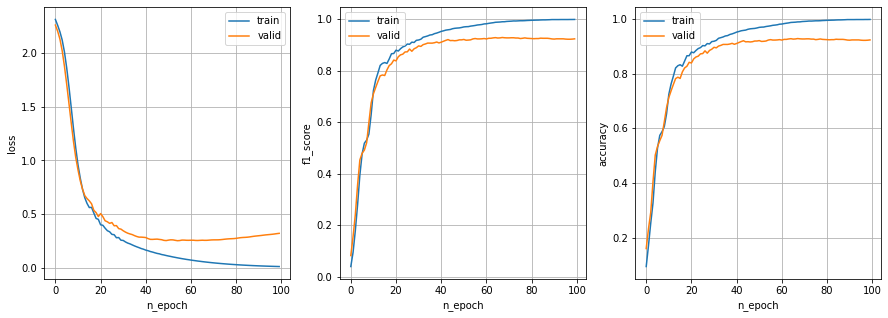

In [14]:
input_dim = 28*28
out_dim = 10
hidden = 60

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),    
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),    
    torch.nn.ReLU(),               
    torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

train_valid(model,100,optimizer,criterion)

In [15]:
#-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3413091003894806, f1: 0.9271945618798025, acc: 0.9274193644523621


## Regularización

Un mecanismo que permite evitar el sobreajuste es conocido como **regularización**. La cantidad de regularización afectará el rendimiento de validación del modelo. Muy poca regularización no resolverá el problema de sobreajuste. Demasiada regularización hará que el modelo sea mucho menos efectivo. La regularización actúa como una restricción sobre el conjunto de posibles funciones aprendibles.

<br>

Según [Ian Goodfellow](https://en.wikipedia.org/wiki/Ian_Goodfellow), "*La regularización es cualquier modificación que hacemos a un algoritmo de aprendizaje que tiene como objetivo reducir su error de generalización pero no su error de entrenamiento.*" 

<br>

**Regularización de caída de peso**

La pérdida de peso es la técnica de regularización más común (implementada en Pytorch). En PyTorch, la caída de peso se proporciona como un parámetro para el optimizador *decay_weight*. En [este](https://pytorch.org/docs/stable/optim.html) enlace se muestran otros parámetros que pueden ser usados en los optimizadores.

A la caída de peso también se le llama:
  * L2
  * Ridge

Para la disminución de peso, agregamos un término de penalización en la actualización de los pesos:

$w(x) = w(x) − \eta \nabla x - \alpha \eta x$

Este nuevo término en la actualización lleva los parámetros $w$ ligeramente hacia cero, agregando algo de **decaimiento** en los pesos con cada actualización.

Epoch [1/100], loss: 2.305008888244629. f1:0.04176087157554081 acc: 0.09650000184774399 
Epoch [2/100], loss: 2.2410032749176025. f1:0.1621865101844616 acc: 0.23516666889190674 
Epoch [3/100], loss: 2.15309739112854. f1:0.2666372117920173 acc: 0.34183332324028015 
Epoch [4/100], loss: 2.0372307300567627. f1:0.34171612998552675 acc: 0.39133334159851074 
Epoch [5/100], loss: 1.8981510400772095. f1:0.3830362940452876 acc: 0.4235000014305115 
Epoch [6/100], loss: 1.746296763420105. f1:0.44688707758276874 acc: 0.4830000102519989 
Epoch [7/100], loss: 1.5816463232040405. f1:0.5528082225847062 acc: 0.5680000185966492 
Epoch [8/100], loss: 1.4088046550750732. f1:0.634135866247361 acc: 0.6439999938011169 
Epoch [9/100], loss: 1.2340461015701294. f1:0.6907446064188896 acc: 0.6959999799728394 
Epoch [10/100], loss: 1.0711919069290161. f1:0.7151961328414929 acc: 0.7213333249092102 
Epoch [11/100], loss: 0.9353795647621155. f1:0.7245347943200551 acc: 0.7329999804496765 
Epoch [12/100], loss: 0.8283

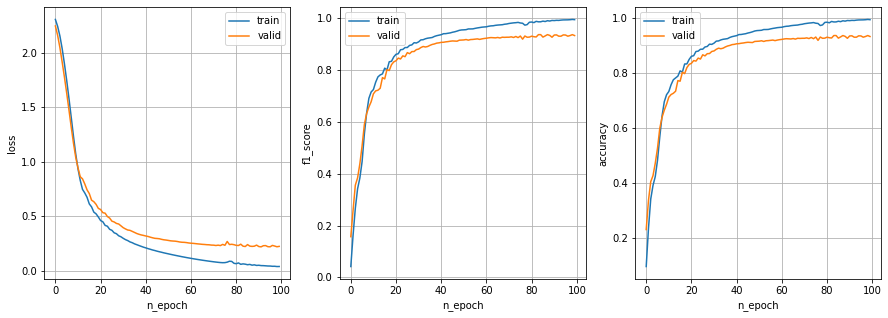

In [16]:
input_dim = 28*28
out_dim = 10
hidden = 60

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),       
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),    
    torch.nn.ReLU(),           
    torch.nn.Linear(hidden, hidden),    
    torch.nn.ReLU(),               
    torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_valid(model,100,optimizer,criterion)

In [17]:
 #-- Evaluamos el modelo entrenado con el set de testeo
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.22102497518062592, f1: 0.9402813616784537, acc: 0.9405242204666138
